In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from utils import rnmse
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset
from neuralop import FNO
import pandas as pd
import seaborn as sns
import matplotlib
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('hot', n_colors=7)
plt.rc('text', usetex=True)      

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [19]:
x = torch.cat([torch.load("../dataset/x_train.pt"), torch.load("../dataset/x_train_2.pt")])
y = torch.cat([torch.load("../dataset/y_train.pt"), torch.load("../dataset/y_train_2.pt")])
c = torch.cat([torch.load("../dataset/c_train.pt"), torch.load("../dataset/c_train_2.pt")])

x_test = torch.load("../dataset/x_test.pt")
y_test = torch.load("../dataset/y_test.pt")
c_test = torch.load("../dataset/c_test.pt")

In [20]:
x.shape

torch.Size([27000, 256, 128])

In [21]:
x_np, y_np, c_np = x.numpy(), y.numpy(), c.numpy()
x_np_reshaped, y_np_reshaped, c_np_reshaped = x_np.reshape((x_np.shape[0], -1)), y_np.reshape((y_np.shape[0], -1)), c_np.reshape((c_np.shape[0], -1))
x_test_np, y_test_np, c_test_np = x_test.numpy(), y_test.numpy(), c_test.numpy()
x_test_np_reshaped, y_test_np_reshaped, c_test_np_reshaped = x_test_np.reshape((x_test_np.shape[0], -1)), y_test_np.reshape((y_test_np.shape[0], -1)), c_test_np.reshape((c_test_np.shape[0], -1))

In [22]:
class DoNothingRegressor(BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y):
        pass
    def predict(self, X):
        return np.zeros_like(X)

In [23]:
class VanillaRegressor(BaseEstimator):
    def __init__(self, regressor, n_components=64):
        self.regressor = regressor
        self.n_components = n_components
        self.pipe = TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=self.n_components)),
                ("reg", self.regressor)
            ]),
            transformer=PCA(n_components=self.n_components),
            check_inverse=False
        )

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

In [24]:
class ResidualRegressor(BaseEstimator):
    def __init__(self, regressor, n_components=64):
        self.n_components = n_components
        self.pipe_lm = TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=self.n_components)),
                ("lm", LinearRegression(n_jobs=-1))
            ]),
            transformer=PCA(n_components=self.n_components),
            check_inverse=False
        )
        self.regressor = regressor

    def fit(self, X, y):
        self.pipe_lm.fit(X, y)
        y_hat_lm = self.pipe_lm.predict(X)
        self.regressor.fit(X, y-y_hat_lm)

    def predict(self, X):
        return self.regressor.predict(X) + self.pipe_lm.predict(X)

In [25]:
def scorer_rnmse(estimator, x, y):
    return rnmse(estimator.predict(x), y)

In [26]:
n_points = x.shape[0]
n_cv = 5
n_epochs = 500
n_components_pca = 512

In [27]:
scores = {}

In [ ]:
scores["Residual PCR"] = cross_val_score(
    ResidualRegressor(DoNothingRegressor(), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
scores["Residual KNN"] = cross_val_score(
    ResidualRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("knn", KNeighborsRegressor(10))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
scores["Vanilla KNN"] = cross_val_score(
    VanillaRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("knn", KNeighborsRegressor(10))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

In [ ]:
from sklearn.neural_network import MLPRegressor
scores["Residual MLP"] = cross_val_score(
    ResidualRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("mlp", MLPRegressor(max_iter=1000))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

In [ ]:
from sklearn.neural_network import MLPRegressor
scores["Vanilla MLP"] = cross_val_score(
    VanillaRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("mlp", MLPRegressor(max_iter=n_epochs))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_dim=n_components_pca, output_dim=n_components_pca):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return x + self.head(self.features(x.unsqueeze(1)))

In [17]:
def get_rnmse():
    return rnmse

device = 'mps'

In [ ]:
from skorch import NeuralNet

pipe_cnn = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components_pca)),
        ("cnn", NeuralNet(
            CNN,
            max_epochs=n_epochs,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))]),
    transformer=PCA(n_components=n_components_pca),
    check_inverse=False
)

scores["Vanilla CNN"] = cross_val_score(
    pipe_cnn,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

data = pd.DataFrame(scores)[sorted(scores, key=lambda x: np.mean(scores[x]), reverse=True)]
data.to_csv('results.csv')
data

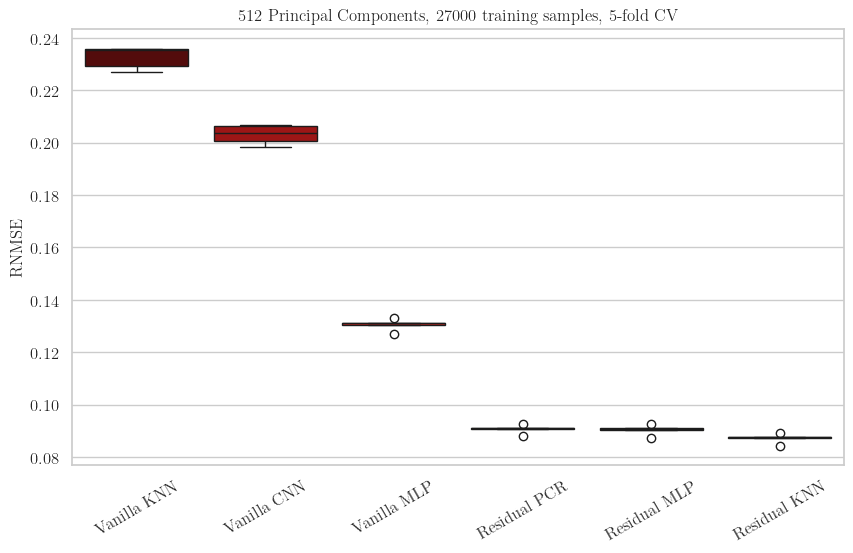

In [13]:
data = pd.read_csv("results.csv")
del data["Vanilla LM"]
plt.figure(figsize=(9, 6))
plt.title(f"{n_components_pca} Principal Components, {n_points} training samples, {n_cv}-fold CV")
sns.boxplot(data)
plt.ylabel("RNMSE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('results.jpg', dpi=150)
plt.show()

In [16]:
data.mean(), data.std()

(Vanilla KNN     0.232599
 Vanilla CNN     0.203123
 Vanilla MLP     0.130574
 Residual PCR    0.090707
 Residual MLP    0.090468
 Residual KNN    0.087188
 dtype: float64,
 Vanilla KNN     0.004243
 Vanilla CNN     0.003659
 Vanilla MLP     0.002257
 Residual PCR    0.001651
 Residual MLP    0.001930
 Residual KNN    0.001696
 dtype: float64)